# Setup

In [73]:
import numpy as np
import nltk
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from matplotlib import pyplot as plt

nltk.download('stopwords', quiet=True)
sns.set()

In [4]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/UC3M/CUARTO/CS577 - NLP/FINAL'
path = '/content/drive/MyDrive/FINAL'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

## Visualisation

In [5]:
import pandas as pd

df = pd.read_csv(f'{path}/data/reviews_generated.csv', index_col=0)
df.head()

,score,summary,text,generated_summary
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good quality and a good tasteHaving constipati...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"Improving""Although NOT OVERCOME FOR YOU'RE LOC..."
2,4,"""Delight"" says it all",This is a confection that has been around a fe...,"Tastes Like A Star, Inflict, and A Little Miss..."
3,2,Cough Medicine,If you are looking for the secret ingredient i...,"Robitussinpoo gave up nursing!!Great Price, Gr..."
4,5,Great taffy,Great taffy at a great price. There was a wid...,Great Taffy!The first question is to explain c...


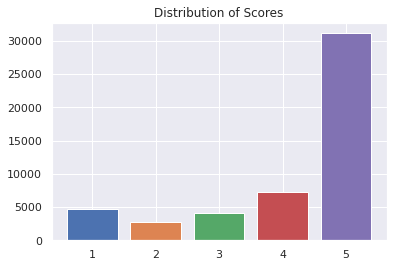

In [74]:
plt.figure()

for i in range(1,6): plt.bar(i,len(df[df['score'] == i]), label=i)

plt.title('Distribution of Scores')
plt.savefig(f'{path}/images/scores.png')
plt.show()

## Preprocessing

In [7]:
import string, re

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

punct = set(string.punctuation)
sw = set(stopwords.words("english"))
ps = PorterStemmer()

def text_prep(text):
    #clean text
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    #remove non-letters and lower case
    text = re.sub('[^a-z\s]', '', text.lower())
    
    #remove punctuation        
    punc_removed = [char for char in text if char not in punct]
    punc_removed = ''.join(punc_removed)
    
    #stem and remove stop words
    stop_removed = [ps.stem(word) for word in punc_removed.split() if not word in sw]
    return ' '.join(stop_removed)

In [77]:
scores_map = {
    1: 0, # Negative Sentiment
    2: 0, # Negative Sentiment
    3: 1, # Neutral Sentiment
    4: 2, # Posirive Sentiment
    5: 2  # Positive Sentiment
}

df['label'] = df['score'].apply(lambda x: scores_map[x])
n_samples = len(df)
class_weight = {}

for label in df['label'].unique(): class_weight[label] = len(df[df['label']==label])/n_samples

class_weight

{0: 0.15068, 1: 0.08094, 2: 0.76838}

In [ ]:
df['text'] = df['text'].apply(text_prep)
df['summary'] = df['summary'].apply(text_prep)
df['generated_summary'] = df['generated_summary'].values.astype('U')
df['generated_summary'] = df['generated_summary'].apply(text_prep)

In [9]:
test = df.sample(frac=0.1, axis=0)
train = df.drop(index=test.index)

y_test = test['label']
y_train = train['label']

len(train), len(test)

(45000, 5000)

# Models

## Utils

In [43]:
def compute_metrics(y_pred, y):
    precision = round(metrics.precision_score(y,y_pred, average='weighted'),2)
    recall = round(metrics.recall_score(y, y_pred, average='weighted'),2)
    f1 = round(metrics.f1_score(y, y_pred, average='weighted'),2)

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')

    return precision, recall, f1


def plot_confusion_matrix(y_pred, y, name, model):
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm = np.round(cm, 2)
    sns.heatmap(cm, annot=True, vmin=0, vmax=1, cmap=plt.cm.Blues, linewidths=.5)
    plt.title(f'Confusion matrix for {model} trained on {name}')
    plt.savefig(f'{path}/images/{model}_{name.replace(" ", "_")}_confusion.png')
    plt.show()

def plot_acc(history, name):
    plt.plot(history.history['accuracy'], 'b', label='Train')
    plt.plot(history.history['val_accuracy'], 'r', label='Valid')
    plt.title(f'Accuracy for lstm trained on {name}'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{path}/images/lstm_{name.replace(" ", "_")}_acc.png')
    plt.show()

def plot_loss(history, name):
    plt.plot(history.history['loss'], 'b', label='Train')
    plt.plot(history.history['val_loss'], 'r', label='Valid')
    plt.title(f'Loss for lstm trained on {name}'),
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{path}/images/lstm_{name.replace(" ", "_")}_loss.png')
    plt.show()

def plot_metrics(text_metrics, summary_metrics, generated_summary_metrics, model):
  model_metrics = [text_metrics, summary_metrics, generated_summary_metrics]
  
  precision = []
  recall = []
  f1 = []

  for i in range(3):
    precision.append(model_metrics[i][0])
    recall.append(model_metrics[i][1])
    f1.append(model_metrics[i][2])

  N = len(model_metrics)
  ind = np.arange(N) 
  width = 0.25
    
  plt.bar(ind+width*0, precision, width, color = 'r', label='Precision')
  plt.bar(ind+width*1, recall,    width, color = 'g', label='Recall')
  plt.bar(ind+width*2, f1,        width, color = 'b', label='F1')
    
  plt.xlabel("Training Attribute")
  plt.ylabel('Scores')
  plt.title(f'Metrics for {model} for training attribute')
    
  plt.xticks(ind+width,['Text', 'Summary', 'Generated Summary'])
  plt.legend(loc='lower right')
  plt.savefig(f'{path}/images/{model}_metrics.png')
  plt.show()


## Logistic Regression

### Feature Extraction

In [89]:
cv= CountVectorizer(binary=True, min_df = 10, max_df = 0.95)

cv.fit(train['text'])
train_text = cv.transform(train['text'])
test_text = cv.transform(test['text'])

In [90]:
cv.fit(train['summary'])
train_summary = cv.transform(train['summary'])
test_summary = cv.transform(test['summary'])

In [91]:
cv.fit(train['generated_summary'].values.astype('U'))
train_generated_summary = cv.transform(train['generated_summary'].values.astype('U'))
test_generated_summary = cv.transform(test['generated_summary'].values.astype('U'))

### Text

In [96]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = 42, max_iter = 1000)

lr.fit(train_text, y_train)
y_pred = lr.predict(test_text)

Precision: 0.83
Recall: 0.84
F1: 0.83


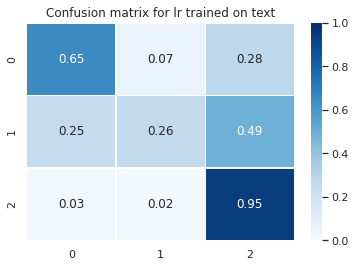

In [97]:
lr_text_metrics = compute_metrics(y_pred, y_test)
plot_confusion_matrix(y_pred, y_test, 'text', 'lr')

### Summary

In [49]:
lr.fit(train_summary, y_train)
y_pred = lr.predict(test_summary)

Precision: 0.81
Recall: 0.83
F1: 0.81


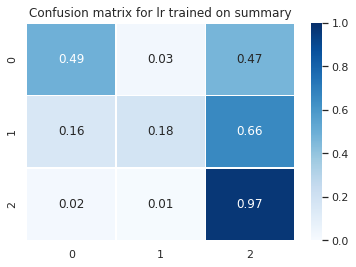

In [50]:
lr_summary_metrics = compute_metrics(y_pred, y_test)
plot_confusion_matrix(y_pred, y_test, 'summary', 'lr')

### Generated Summary

In [51]:
lr.fit(train_generated_summary, y_train)
y_pred = lr.predict(test_generated_summary)

Precision: 0.63
Recall: 0.76
F1: 0.66


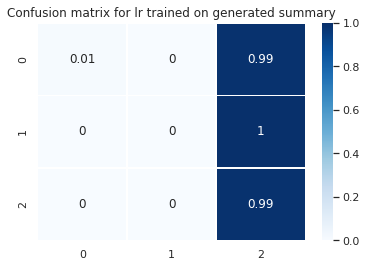

In [52]:
lr_generated_summary_metrics = compute_metrics(y_pred, y_test)
plot_confusion_matrix(y_pred, y_test, 'generated summary', 'lr')

### Evaluation

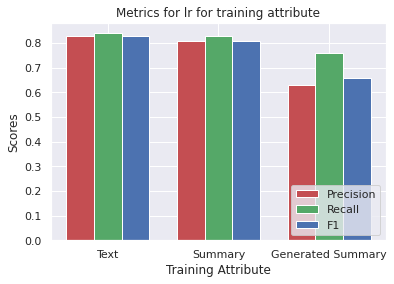

In [53]:
sns.set()
plot_metrics(lr_text_metrics, lr_summary_metrics, lr_generated_summary_metrics, 'lr')


## LSTM

### Feature Extraction

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 5000
max_len   = 200
tokenizer = Tokenizer(num_words)

tokenizer.fit_on_texts(train['text'])
train_text = tokenizer.texts_to_sequences(train['text'])
train_text = pad_sequences(train_text, max_len)

test_text = tokenizer.texts_to_sequences(test['text'])
test_text = pad_sequences(test_text, max_len)

In [55]:
tokenizer.fit_on_texts(train['summary'])
train_summary = tokenizer.texts_to_sequences(train['summary'])
train_summary = pad_sequences(train_summary, max_len)

test_summary = tokenizer.texts_to_sequences(test['summary'])
test_summary = pad_sequences(test_summary, max_len)

In [56]:
tokenizer.fit_on_texts(train['generated_summary'])
train_generated_summary = tokenizer.texts_to_sequences(train['generated_summary'])
train_generated_summary = pad_sequences(train_generated_summary, max_len)

test_generated_summary = tokenizer.texts_to_sequences(test['generated_summary'])
test_generated_summary = pad_sequences(test_generated_summary, max_len)

In [57]:
y_train_ohe = pd.get_dummies(y_train).to_numpy()

### Model

In [58]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, SpatialDropout1D

def lstm(max_len, num_classes):
    input = Input(shape=(max_len, ))
    x = Embedding(num_words, 300)(input)
    x = LSTM(100, dropout=0.5)(x)

    if num_classes == 2:
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
        units = 1
    else:
        activation = 'softmax'
        loss = 'categorical_crossentropy'
        units = num_classes

    x = Dense(units, activation=activation)(x)
    model = Model(inputs=input, outputs=x)
    return model
  

In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

bacth_size = 256
epochs = 20

### Text

In [60]:
model = lstm(max_len, len(y_train.unique()))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
      EarlyStopping(
          monitor="val_loss",
          patience=10,
          restore_best_weights=True
      ),
      ModelCheckpoint(
          f'{path}/models/lstm/text',
          monitor="val_loss",
          save_best_only=True
      )
]

history = model.fit(
            train_text, 
            y_train_ohe, 
            batch_size=bacth_size, 
            validation_split=0.1, 
            epochs=epochs,
            callbacks = callbacks
          )

Epoch 1/20
158/159 [============================>.] - ETA: 0s - loss: 0.5373 - accuracy: 0.8068

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/text/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/text/assets


159/159 [==============================] - 24s 131ms/step - loss: 0.5372 - accuracy: 0.8068 - val_loss: 0.4823 - val_accuracy: 0.8233
Epoch 2/20
158/159 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8548

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/text/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/text/assets


159/159 [==============================] - 20s 126ms/step - loss: 0.3914 - accuracy: 0.8546 - val_loss: 0.4607 - val_accuracy: 0.8240
Epoch 3/20
159/159 [==============================] - 14s 86ms/step - loss: 0.3438 - accuracy: 0.8716 - val_loss: 0.4626 - val_accuracy: 0.8253
Epoch 4/20
159/159 [==============================] - 13s 84ms/step - loss: 0.3125 - accuracy: 0.8850 - val_loss: 0.4970 - val_accuracy: 0.8253
Epoch 5/20
159/159 [==============================] - 14s 88ms/step - loss: 0.2817 - accuracy: 0.8952 - val_loss: 0.5376 - val_accuracy: 0.8207
Epoch 6/20
159/159 [==============================] - 13s 85ms/step - loss: 0.2611 - accuracy: 0.9028 - val_loss: 0.5747 - val_accuracy: 0.8198
Epoch 7/20
159/159 [==============================] - 14s 86ms/step - loss: 0.2388 - accuracy: 0.9113 - val_loss: 0.5567 - val_accuracy: 0.8211
Epoch 8/20
159/159 [==============================] - 13s 84ms/step - loss: 0.2147 - accuracy: 0.9220 - val_loss: 0.6313 - val_accuracy: 0.8011
Ep

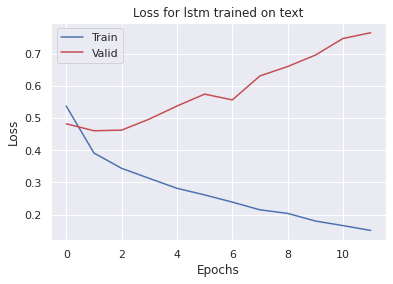

In [61]:
plot_loss(history, 'text')

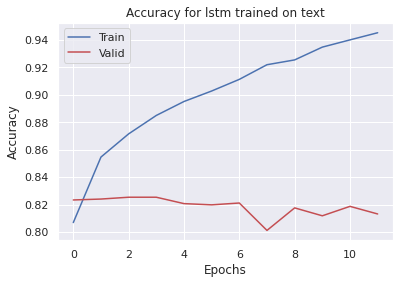

In [62]:
plot_acc(history, 'text')

Precision: 0.82
Recall: 0.84
F1: 0.83


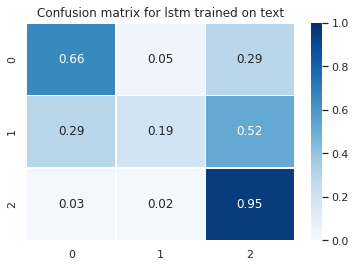

In [63]:
y_pred = model.predict(test_text).argmax(axis=1)

lstm_text_metrics = compute_metrics(y_pred, y_test)
plot_confusion_matrix(y_pred, y_test, 'text', 'lstm')

### Summary

In [64]:
model = lstm(max_len, len(y_train.unique()))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
      EarlyStopping(
          monitor="val_loss",
          patience=10,
          restore_best_weights=True
      ),
      ModelCheckpoint(
          f'{path}/models/lstm/summary',
          monitor="val_loss",
          save_best_only=True
      )
]

history = model.fit(
            train_text, 
            y_train_ohe, 
            batch_size=bacth_size, 
            validation_split=0.1, 
            epochs=epochs,
            callbacks = callbacks
          )

Epoch 1/20
158/159 [============================>.] - ETA: 0s - loss: 0.5387 - accuracy: 0.8067

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/summary/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/summary/assets


159/159 [==============================] - 23s 129ms/step - loss: 0.5388 - accuracy: 0.8067 - val_loss: 0.4755 - val_accuracy: 0.8247
Epoch 2/20
159/159 [==============================] - 13s 85ms/step - loss: 0.3947 - accuracy: 0.8535 - val_loss: 0.5015 - val_accuracy: 0.8196
Epoch 3/20
158/159 [============================>.] - ETA: 0s - loss: 0.3478 - accuracy: 0.8690

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/summary/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/summary/assets


159/159 [==============================] - 20s 124ms/step - loss: 0.3479 - accuracy: 0.8690 - val_loss: 0.4700 - val_accuracy: 0.8227
Epoch 4/20
159/159 [==============================] - 14s 85ms/step - loss: 0.3149 - accuracy: 0.8812 - val_loss: 0.4820 - val_accuracy: 0.8231
Epoch 5/20
159/159 [==============================] - 13s 85ms/step - loss: 0.2871 - accuracy: 0.8930 - val_loss: 0.5385 - val_accuracy: 0.8160
Epoch 6/20
159/159 [==============================] - 14s 85ms/step - loss: 0.2628 - accuracy: 0.9017 - val_loss: 0.5648 - val_accuracy: 0.8191
Epoch 7/20
159/159 [==============================] - 13s 85ms/step - loss: 0.2361 - accuracy: 0.9122 - val_loss: 0.5704 - val_accuracy: 0.8151
Epoch 8/20
159/159 [==============================] - 14s 85ms/step - loss: 0.2152 - accuracy: 0.9213 - val_loss: 0.6023 - val_accuracy: 0.8176
Epoch 9/20
159/159 [==============================] - 14s 85ms/step - loss: 0.1923 - accuracy: 0.9296 - val_loss: 0.6244 - val_accuracy: 0.8180
Ep

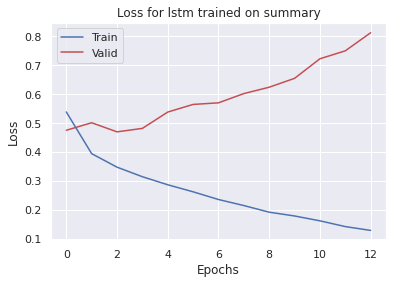

In [65]:
plot_loss(history, 'summary')

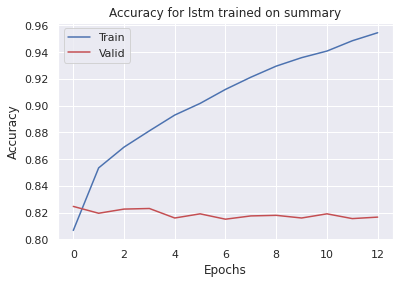

In [66]:
plot_acc(history, 'summary')

Precision: 0.63
Recall: 0.62
F1: 0.62


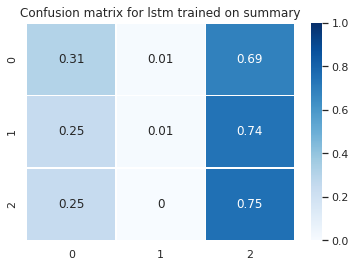

In [67]:
y_pred = model.predict(test_summary).argmax(axis=1)

lstm_summary_metrics = compute_metrics(y_pred, y_test)
plot_confusion_matrix(y_pred, y_test, 'summary', 'lstm')

### Generated Summary

In [68]:
model = lstm(max_len, len(y_train.unique()))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
      EarlyStopping(
          monitor="val_loss",
          patience=10,
          restore_best_weights=True
      ),
      ModelCheckpoint(
          f'{path}/models/lstm/generated_summary',
          monitor="val_loss",
          save_best_only=True
      )
]

history = model.fit(
            train_text, 
            y_train_ohe, 
            batch_size=bacth_size, 
            validation_split=0.1, 
            epochs=epochs,
            callbacks = callbacks
          )

Epoch 1/20
158/159 [============================>.] - ETA: 0s - loss: 0.5486 - accuracy: 0.8030

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/generated_summary/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/generated_summary/assets


159/159 [==============================] - 24s 133ms/step - loss: 0.5486 - accuracy: 0.8030 - val_loss: 0.4933 - val_accuracy: 0.8220
Epoch 2/20
158/159 [============================>.] - ETA: 0s - loss: 0.3928 - accuracy: 0.8528

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/generated_summary/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FINAL/models/lstm/generated_summary/assets


159/159 [==============================] - 20s 126ms/step - loss: 0.3929 - accuracy: 0.8528 - val_loss: 0.4775 - val_accuracy: 0.8236
Epoch 3/20
159/159 [==============================] - 13s 84ms/step - loss: 0.3462 - accuracy: 0.8705 - val_loss: 0.4804 - val_accuracy: 0.8167
Epoch 4/20
159/159 [==============================] - 13s 84ms/step - loss: 0.3150 - accuracy: 0.8826 - val_loss: 0.4953 - val_accuracy: 0.8220
Epoch 5/20
159/159 [==============================] - 13s 85ms/step - loss: 0.2854 - accuracy: 0.8945 - val_loss: 0.5114 - val_accuracy: 0.8178
Epoch 6/20
159/159 [==============================] - 13s 85ms/step - loss: 0.2623 - accuracy: 0.9020 - val_loss: 0.5599 - val_accuracy: 0.8202
Epoch 7/20
159/159 [==============================] - 13s 85ms/step - loss: 0.2337 - accuracy: 0.9136 - val_loss: 0.5852 - val_accuracy: 0.8204
Epoch 8/20
159/159 [==============================] - 14s 85ms/step - loss: 0.2122 - accuracy: 0.9219 - val_loss: 0.5913 - val_accuracy: 0.8169
Ep

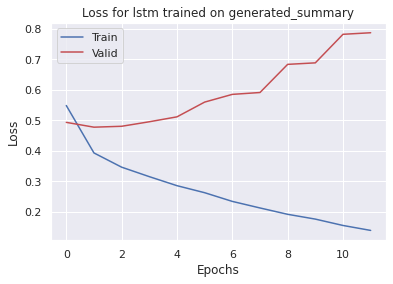

In [69]:
plot_loss(history, 'generated_summary')

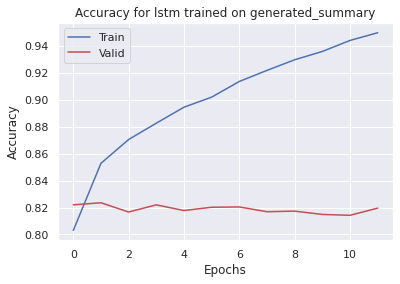

In [70]:
plot_acc(history, 'generated_summary')

Precision: 0.63
Recall: 0.67
F1: 0.65


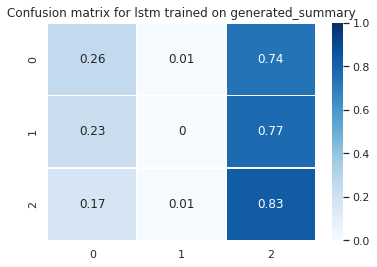

In [71]:
y_pred = model.predict(test_summary).argmax(axis=1)

lstm_generated_summary_metrics = compute_metrics(y_pred, y_test)
plot_confusion_matrix(y_pred, y_test, 'generated_summary', 'lstm')

### Evaluation

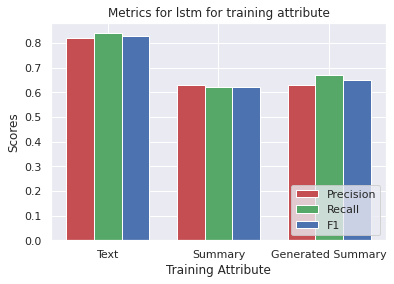

In [72]:
plot_metrics(lstm_text_metrics, lstm_summary_metrics, lstm_generated_summary_metrics, 'lstm')